In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import cv2
import tensorflow
import numpy as np
import os
from keras import backend as K
import keras
from keras.models import Sequential, Model
optimizer = tensorflow.keras.optimizers.RMSprop()
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Flatten, Convolution2D, AveragePooling2D, MaxPooling2D
from keras.initializers import glorot_uniform
from PIL import Image
from keras.layers import LeakyReLU, Concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from typing import List, Tuple

import keras.backend as K
import keras.layers
import tensorflow as tf
from keras import optimizers
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D, Reshape, Multiply
from keras.layers import Convolution1D, Dense,Input,MaxPooling3D, AveragePooling3D, LSTM
from keras.models import Model

In [ ]:
trg_data = "/content/drive/MyDrive/Datasets/Dataset_8/"
img_rows = 150
img_cols = 150
maxToAdd =  2700
nb_classes = 7
class_labels = {0 :"Box", 1 : "Jog", 2 : "Handclap", 3 : "Handwave", 4 : "Walk", 5 : "Run", 6: "Carrying"}

In [ ]:
from keras.utils import to_categorical
def load_data_for_persons():
  data_array = []
  classes_array = []

  for i in class_labels:
    class_folder = trg_data + class_labels[i]
    D_Count, d_path = dataset_load_Number(class_folder)
    for j in d_path:
      print(j)
      img_folder = [im for im in os.listdir(j)]
      img_folder.sort()
      print(len(img_folder))
      for m in range(0, img_to_add):
        file_path = j + img_folder[m]
        print(file_path)
        data = cv2.imread(file_path)
        data_gray = cv2.resize(data, (img_cols,img_rows), interpolation = cv2.INTER_AREA)
        data_gray = data_gray/255.0
        data_array.append(data_gray)
        classes_array.append(i)

    print(f"class_label {class_labels[i]}  is done")

  classes_array = to_categorical(classes_array)

  x_train, x_test, Y_train, Y_test = train_test_split(np.array(data_array), classes_array, test_size=0.2, random_state=42)
  x_test, x_val, Y_test, Y_val = train_test_split(x_test, Y_test, test_size=0.75, random_state=42)

  print("the ytrain length is : ", classes_array.shape)
  print("the xtrain length is :", np.array(data_array).shape)

  return x_train, x_test, Y_train, Y_test, x_val, Y_val

In [ ]:
print ("Loading data")
# load training data
x_train, x_test, Y_train, Y_test,x_val, Y_val = load_data_for_persons()
print("loading is done")

In [ ]:
print("length of x_train : ", len(x_train))
print("length of Y_train : ", len(Y_train))
print("length of x_test : ", len(x_test))
print("length of Y_test : ", len(Y_test))
print("length of x_val : ", len(x_val))
print("length of Y_val : ", len(Y_val))

print("shape of x_train : ", x_train[0].shape)
print("shape of x_train : ", Y_train[0].shape)


length of x_train :  15120
length of Y_train :  15120
length of x_test :  945
length of Y_test :  945
length of x_val :  2835
length of Y_val :  2835
shape of x_train :  (150, 150, 3)
shape of x_train :  (7,)


In [ ]:
inputlayer = Input(shape = (img_rows,img_cols,3), batch_size = 25)

In [ ]:
import tensorflow as tf

def basic_Conv(x, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
    conv = Conv2D(out_planes, kernel_size=kernel_size, strides=stride, padding=padding, dilation_rate=dilation, groups=groups, use_bias=bias)(x)
    if bn:
        conv = BatchNormalization(epsilon=1e-5, momentum=0.01, trainable=True)(conv)
    if relu:
        conv = Activation("relu")(conv)
    return conv

def channelPooling(x):
    max_pool = tf.reduce_max(x, axis=3, keepdims=True)
    mean_pool = tf.reduce_mean(x, axis=3, keepdims=True)
    return tf.concat([max_pool, mean_pool], axis=3)

def spatial_attention(x):
  x_compress = channelPooling(x)
  x_out = basic_Conv(x_compress, 2, 1, kernel_size, stride=1, padding="same", relu=False)
  scale = tf.sigmoid(x_out)
  output_tensor = Multiply()([x, scale])
  return output_tensor

In [ ]:
X = spatial_attention(inputlayer)

pretrained_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(img_rows, img_cols, 3), pooling=None, weights= None)

new_model = Model(inputs=pretrained_model.input, outputs=out_layer)

X_out = new_model(X)
X_out = AveragePooling2D(pool_size=(2, 2))(X_out)
X_out = Flatten()(X_out)

X = Convolution2D(16, (3, 3), strides = (1,1),padding = "valid")(X)
X = BatchNormalization()(X)
X = LeakyReLU(alpha = 0.1)(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Convolution2D(64, (3, 3), strides = (1,1),padding = "valid")(X)
X = BatchNormalization()(X)
X = LeakyReLU(alpha = 0.1)(X)
X = MaxPooling2D(pool_size=(2, 2))(X)

X = Convolution2D(128, (1, 1), strides = (1,1),padding = "valid")(X)
X = BatchNormalization()(X)
X = LeakyReLU(alpha = 0.1)(X)
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Flatten()(X)

X_output = Concatenate()([X_out, X])

In [ ]:
def channelPoolingTemporal(x):
    max_pool = tf.reduce_max(x, axis=2, keepdims=True)
    mean_pool = tf.reduce_mean(x, axis=2, keepdims=True)
    return tf.concat([max_pool, mean_pool], axis=2)

def TemporalAttention(x):
    x = tf.reduce_mean(x, axis=1)
    x_compress = channelPoolingTemporal(x)
    y = LSTM(units= units, return_sequences=True)(x_compress)
    attention_weights = Dense(1, activation='sigmoid')(y)
    output_tensor = Multiply()([x, attention_weights])
    return output_tensor

In [ ]:
leaky = LeakyReLU(0.1)
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, activation, dropout_rate=0):
    prev_x = x
    x = Conv1D(filters=nb_filters[0], kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.1)(x)

    x = SpatialDropout1D(rate=dropout_rate)(x)

    x = Conv1D(filters=nb_filters[1], kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha = 0.1)(x)

    x = SpatialDropout1D(rate=dropout_rate)(x)

    prev_x = Conv1D(nb_filters[1], 1, padding='same')(prev_x)
    res_x = keras.layers.add([prev_x, x])
    res_x = Activation(activation)(res_x)
    return res_x, x

def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations
class TCN:
    def __init__(self, nb_filters=nb_filters, kernel_size= kernel_size, nb_stacks=1, dilations=[1, 2, 4, 8], padding='causal', use_skip_connections=True, dropout_rate=0.0, return_sequences=False):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding

    def __call__(self, inputs):
        x = inputs
        x = Convolution1D(self.nb_filters[0], 1, padding=self.padding)(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for d in self.dilations:
                x, skip_out = residual_block(x, dilation_rate=d, nb_filters=self.nb_filters, kernel_size=self.kernel_size, padding=self.padding, dropout_rate=self.dropout_rate)
                skip_connections.append(skip_out)
        return x

class TemporalFeaturesExtraction:
    def __init__(self, nb_filters, kernel_size, dilations, nb_stacks, max_len, padding='causal', use_skip_connections=True, return_sequences=True, dropout_rate=0.5):
        #self.num_feat = num_feat
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.max_len = max_len
        self.padding = padding
        self.use_skip_connections = use_skip_connections
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate


    def __call__(self, inputs):
        in_features = inputs
        dilations = process_dilations(self.dilations)
        features_temporal = TCN(self.nb_filters, self.kernel_size, self.nb_stacks, dilations, self.padding, self.use_skip_connections, self.dropout_rate, self.return_sequences)(in_features)

        return features_temporal

In [ ]:
Y = TemporalAttention(inputlayer)
Y_temporal = TemporalFeaturesExtraction(nb_filters = nb_filters, kernel_size = kernel_size, dilations = [1, 2, 4, 8], nb_stacks = 1, max_len = img_rows)(Y)
Y_output = Flatten()(Y_temporal)

In [ ]:
fusion_output = Concatenate()([X_output, Y_output])

In [ ]:
fusion_dense = Dense(256,kernel_regularizer=tf.keras.regularizers.l2(0.01))(fusion_output)
fusion_dense = LeakyReLU(0.1)(fusion_dense)
fusion_dense =Dropout(0.2)(fusion_dense)
fusion_dense = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.01))(fusion_dense)
fusion_dense = LeakyReLU(0.1)(fusion_dense)
fusion_dense = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01))(fusion_dense)
fusion_dense = LeakyReLU(0.1)(fusion_dense)
final_output = Dense(nb_classes, activation='softmax')(fusion_dense)
model_final = Model(inputs = inputlayer, outputs = final_output)

model_final.compile(optimizer = "RMSProp", loss = "categorical_crossentropy", metrics = 'accuracy')
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(25, 150, 150, 3)]          0         []                            
                                                                                                  
 tf.math.reduce_mean_1 (TFO  (25, 150, 3)                 0         ['input_1[0][0]']             
 pLambda)                                                                                         
                                                                                                  
 tf.math.reduce_max_1 (TFOp  (25, 150, 1)                 0         ['tf.math.reduce_mean_1[0][0]'
 Lambda)                                                            ]                             
                                                                                            

In [ ]:
nb_epoch = 50
batch_size = 25

In [ ]:
print("Training.....")
history = model_final.fit(x_train, Y_train,validation_data=(x_val, Y_val), batch_size=batch_size, epochs=nb_epoch, shuffle=True, verbose=1)

Training.....
Epoch 1/50
605/605 [==============================] - 69s 81ms/step - loss: 3.5822 - accuracy: 0.4032 - val_loss: 1.9067 - val_accuracy: 0.4875
Epoch 2/50
605/605 [==============================] - 45s 74ms/step - loss: 1.4909 - accuracy: 0.5821 - val_loss: 1.4495 - val_accuracy: 0.6042
Epoch 3/50
605/605 [==============================] - 44s 74ms/step - loss: 1.1948 - accuracy: 0.6585 - val_loss: 1.0333 - val_accuracy: 0.7132
Epoch 4/50
605/605 [==============================] - 45s 74ms/step - loss: 0.9954 - accuracy: 0.7171 - val_loss: 1.0320 - val_accuracy: 0.7185
Epoch 5/50
605/605 [==============================] - 44s 74ms/step - loss: 0.8584 - accuracy: 0.7627 - val_loss: 0.9253 - val_accuracy: 0.7358
Epoch 6/50
605/605 [==============================] - 45s 74ms/step - loss: 0.7201 - accuracy: 0.8067 - val_loss: 0.8779 - val_accuracy: 0.7496
Epoch 7/50
605/605 [==============================] - 45s 74ms/step - loss: 0.6162 - accuracy: 0.8481 - val_loss: 0.7874 -

In [ ]:
preds = model_final.predict(x_test)
confusion_matrix = np.zeros(shape=(Y_test.shape[1],Y_test.shape[1]))
accurate_count = 0.0
for i in range(0,len(preds)):
    print ('Predicted: ', np.argmax(preds[i]), ', actual: ', np.argmax(Y_test[i]))

    # calculating overall accuracy
    if np.argmax(preds[i])==np.argmax(Y_test[i]):
        accurate_count += 1

print('Validation accuracy: ', 100*accurate_count/len(preds)),' %'
print('Confusion matrix:')
print(class_labels)
print(confusion_matrix)

30/30 [==============================] - 4s 50ms/step
Predicted:  3 , actual:  3
Predicted:  1 , actual:  1
Predicted:  5 , actual:  5
Predicted:  5 , actual:  5
Predicted:  3 , actual:  3
Predicted:  6 , actual:  6
Predicted:  6 , actual:  6
Predicted:  0 , actual:  0
Predicted:  1 , actual:  1
Predicted:  1 , actual:  1
Predicted:  1 , actual:  1
Predicted:  1 , actual:  1
Predicted:  1 , actual:  5
Predicted:  6 , actual:  6
Predicted:  6 , actual:  6
Predicted:  6 , actual:  6
Predicted:  1 , actual:  1
Predicted:  0 , actual:  0
Predicted:  1 , actual:  1
Predicted:  5 , actual:  5
Predicted:  1 , actual:  1
Predicted:  2 , actual:  2
Predicted:  5 , actual:  5
Predicted:  5 , actual:  5
Predicted:  5 , actual:  5
Predicted:  6 , actual:  6
Predicted:  6 , actual:  6
Predicted:  6 , actual:  6
Predicted:  0 , actual:  0
Predicted:  5 , actual:  5
Predicted:  5 , actual:  1
Predicted:  4 , actual:  4
Predicted:  2 , actual:  0
Predicted:  6 , actual:  6
Predicted:  1 , actual:  1
P

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

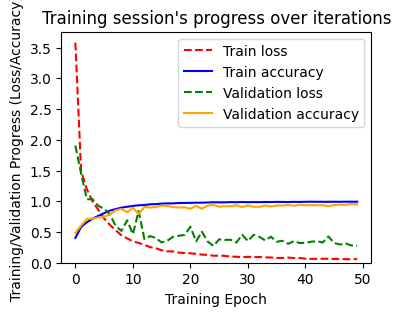

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(np.array(history.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history.history['accuracy']), "b-", label = "Train accuracy")
plt.plot(np.array(history.history['val_loss']), "g--", label = "Validation loss")
plt.plot(np.array(history.history['val_accuracy']), "orange", label = "Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right')
plt.ylabel('Training/Validation Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
loss, accuracy = model_final.evaluate(x_test, Y_test, batch_size = 20, verbose = 1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

48/48 [==============================] - 2s 33ms/step - loss: 0.2804 - accuracy: 0.9556
Test Accuracy : 0.9555555582046509
Test Loss : 0.28036704659461975


30/30 [==============================] - 1s 28ms/step


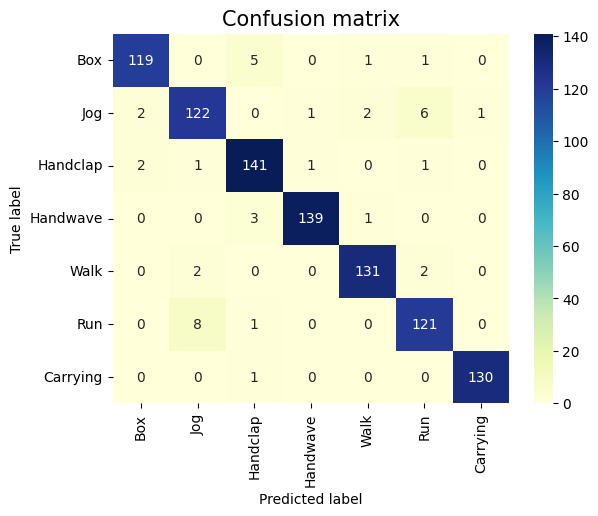

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model_final.predict(x_test)
class_label = ["Box","Jog", "Handclap", "Handwave", "Walk", "Run","Carrying"]
max_test = np.argmax(Y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels = class_label, yticklabels = class_label, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model_final.save('/content/drive/MyDrive/Datasets/Dataset_8/UCF_ARG_Test.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
